In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(10754)
from scipy.stats import foldnorm, norm
import matplotlib.pyplot as plt

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB


Data generation

In [348]:
#Define the number of elements in each set I, J, K
i_num = 10
k_num = 1
j_num = 200 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [349]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 3000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 3000), 0)

I.index = I['Point number']


for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 3000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 3000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 3000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 3000), 0)

J.index = J['Point number']
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,1148.0,1803.0
j1,j1,2654.0,1879.0
j2,j2,935.0,2381.0
j3,j3,1408.0,1361.0
j4,j4,752.0,1681.0
...,...,...,...
i5,i5,2449.0,383.0
i6,i6,884.0,2998.0
i7,i7,2816.0,1153.0


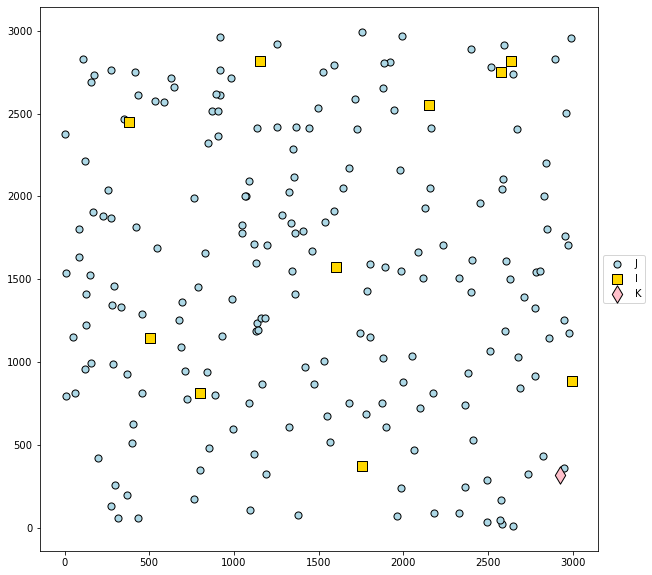

In [350]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [351]:
#Define constants

B = 91800 #battery load: meters of travel
S = 1020 #meters of service time
W = 2500 #max grams of weight

p = 0.1

alpha = 15900 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 203000
    else:
        beta[j] = 76920

gamma = 0.0045 / 1000 # variable cost in euro per m

q_j = {}
for j in J.index:
    if j.startswith('j'):
        q_j[j] = 255
    else:
        q_j[j] = 45



softlimit = 200
hardlimit = 600

In [352]:
#Model termination function

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()

In [353]:
std_dev = {i : random.uniform(10000, 70000) for i in I.index}

#Define random variable

theta_ran_i = {}
for i in list(I.index):
    theta_ran_i[i] = foldnorm(c=0, loc=0, scale=std_dev[i]) 
    
#Define deterministic theta
theta_det = {}
for i in I.index:
    theta_det[i] = theta_ran_i[i].rvs(1)[0]
    
r = len(theta_ran_i.keys()) #r-variate random vector theta

Deterministic model DM

In [354]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}

dist_KJ


{('k0', 'j0'): 1398.427688513067,
 ('k0', 'j1'): 2562.1373889781944,
 ('k0', 'j2'): 825.3950569272874,
 ('k0', 'j3'): 1909.141168169604,
 ('k0', 'j4'): 1320.080300587809,
 ('k0', 'j5'): 2436.5395543680384,
 ('k0', 'j6'): 1224.3202195504246,
 ('k0', 'j7'): 2957.0534320502225,
 ('k0', 'j8'): 3166.310944932604,
 ('k0', 'j9'): 3323.0543179430574,
 ('k0', 'j10'): 415.51052934913696,
 ('k0', 'j11'): 3119.042962192089,
 ('k0', 'j12'): 1550.6376107911224,
 ('k0', 'j13'): 2499.193669966375,
 ('k0', 'j14'): 3006.1330642538096,
 ('k0', 'j15'): 155.79473675320358,
 ('k0', 'j16'): 2568.505596645645,
 ('k0', 'j17'): 1141.3851234355564,
 ('k0', 'j18'): 3609.9203592323197,
 ('k0', 'j19'): 2232.7785380552186,
 ('k0', 'j20'): 2787.7359989783827,
 ('k0', 'j21'): 1555.4822403357743,
 ('k0', 'j22'): 3388.520916270106,
 ('k0', 'j23'): 2067.1918149992757,
 ('k0', 'j24'): 2222.3537072212425,
 ('k0', 'j25'): 3322.110323273446,
 ('k0', 'j26'): 2522.8309495485423,
 ('k0', 'j27'): 1737.0184224699517,
 ('k0', 'j28

In [355]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")

        print("\n")


In [356]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    total_drones = sum(results['Number of drones'])
    total_locations = results['j'].nunique()
    return results_doctors, results_locations, results_labs, f'Total number of drones: {total_drones}', f'Total number of locations: {total_locations}'


In [357]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))

L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [358]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))

P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0')]

In [359]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}

KJ_feas = list(M_kj_final.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [360]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []

N_i_final = {key : val for key, val in N_i.items() if val != []}

I_feas = list(N_i_final.keys())

In [361]:
#Redefine sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []

O_j_final = {key : val for key, val in O_j.items() if val != []}

J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j

Deterministic model (DM)

In [362]:

def AddBasisGurobi(model, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit):

    #Adding basic variables x_ikj and y_j
    x_ikj = model.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
    y_j = model.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')


    #Adding constraints except for demand covering
    model.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'Capacity')
    model.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'Battery')
    model.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'Service time')
    model.addConstrs((y_j[k] == 1 for k in K.index), name = 'Open laboratories')

    #Set objective
    model.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

    #Set parameter TimeLimit
    model.setParam('TimeLimit', hardlimit)

    return x_ikj, y_j


In [363]:

model_DM = gp.Model('DM')

x_ikj, y_j = AddBasisGurobi(model_DM, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

#Add demand constraints
model_DM.addConstrs((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'Demand')

model_DM.optimize(softtime)

Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4442 rows, 2321 columns and 5430 nonzeros
Model fingerprint: 0x56247a96
Variable types: 0 continuous, 2321 integer (211 binary)
Coefficient statistics:
  Matrix range     [2e-01, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Found heuristic solution: objective 4238643.1128
Presolve removed 4242 rows and 1671 columns
Presolve time: 0.01s
Presolved: 200 rows, 650 columns, 1109 nonzeros
Found heuristic solution: objective 4035643.0731
Variable types: 0 continuous, 650 integer (191 binary)
Found heuristic solution: objective 4035643.0631

Root relaxation: objective 2.639383e+06, 446 iterations, 0.00 seconds (0.00 wor

In [364]:
ListSolution(model_DM)

Number of solutions found: 8
0
2.69156e+06 
x_ikj[i0,k0,j21] 25
x_ikj[i1,k0,j21] 22
x_ikj[i2,k0,j21] 10
x_ikj[i3,k0,i4] 4
x_ikj[i4,k0,i4] 33
x_ikj[i5,k0,i5] 29
x_ikj[i6,k0,k0] 7
x_ikj[i7,k0,i5] 2
x_ikj[i8,k0,j21] 5
x_ikj[i9,k0,i4] 5
y_j[j21] 1
y_j[k0] 1
y_j[i4] 1
y_j[i5] 1


1
2.8454e+06 
x_ikj[i0,k0,j21] 25
x_ikj[i1,k0,j21] 22
x_ikj[i2,k0,j21] 10
x_ikj[i3,k0,i4] 4
x_ikj[i4,k0,i4] 33
x_ikj[i5,k0,i5] 29
x_ikj[i6,k0,k0] 7
x_ikj[i7,k0,i5] 2
x_ikj[i8,k0,j21] 5
x_ikj[i9,k0,i4] 5
y_j[j21] 1
y_j[k0] 1
y_j[i4] 1
y_j[i5] 1


2
3.07616e+06 
x_ikj[i0,k0,j21] 25
x_ikj[i1,k0,j21] 22
x_ikj[i2,k0,j21] 10
x_ikj[i3,k0,i4] 4
x_ikj[i4,k0,i4] 33
x_ikj[i5,k0,i5] 29
x_ikj[i6,k0,k0] 7
x_ikj[i7,k0,i5] 2
x_ikj[i8,k0,j21] 5
x_ikj[i9,k0,i4] 5
y_j[j21] 1
y_j[k0] 1
y_j[i4] 1
y_j[i5] 1


3
3.07616e+06 
x_ikj[i0,k0,j21] 25
x_ikj[i1,k0,j21] 22
x_ikj[i2,k0,j21] 10
x_ikj[i3,k0,i4] 4
x_ikj[i4,k0,i4] 33
x_ikj[i5,k0,i5] 29
x_ikj[i6,k0,k0] 7
x_ikj[i7,k0,i5] 2
x_ikj[i8,k0,j21] 5
x_ikj[i9,k0,i4] 5
y_j[j21] 1
y_j[k0] 1
y_j[i4

In [365]:
SolutionSummary(model_DM)

(    i  Number of drones
 0  i0                25
 1  i1                22
 2  i2                10
 3  i3                 4
 4  i4                33
 5  i5                29
 6  i6                 7
 7  i7                 2
 8  i8                 5
 9  i9                 5,
      j  Number of drones
 0   i4                42
 1   i5                31
 2  j21                62
 3   k0                 7,
     k  Number of drones
 0  k0               142,
 'Total number of drones: 142',
 'Total number of locations: 4')

In [366]:
model_BO1 = gp.Model('BO1')

#model_BO1.Params.Presolve = 0

x_ikj, y_j = AddBasisGurobi(model_BO1, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

z_i = model_BO1.addVars(I_feas, lb = 0, vtype = GRB.CONTINUOUS, name = 'z_i')

F_i = model_BO1.addVars(I_feas, lb=0, ub=1, vtype = GRB.CONTINUOUS, name='F_i')
test_F_i = model_BO1.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_F_i')



for i in I_feas:
    
    #Generate mapping z->cdf
    step = 0.005
    ones = [1] * 5
    foldnorm_cdf_values = []
    z_values = []
    foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
    
    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
        
    
    model_BO1.addConstr(z_i[i] == gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]), name = 'Z-replacement')
    
    model_BO1.addGenConstrPWL(xvar=z_i[i], yvar=F_i[i], xpts=z_values, ypts=foldnorm_cdf_values, name="F=cdf(z_i)")
    
    model_BO1.addConstr((F_i[i] >= p), name='Individual probabilistic constraint')
    model_BO1.addConstr(test_F_i[i] == F_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    
    

model_BO1.addConstr((gp.quicksum(F_i[i] for i in I_feas) - r + 1 >= p), name='Joint probabilistic constraint')

model_BO1.update()

Set parameter TimeLimit to value 600


In [367]:
model_BO1.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4463 rows, 2351 columns and 5480 nonzeros
Model fingerprint: 0x8a803db9
Model has 10 general constraints
Variable types: 30 continuous, 2321 integer (211 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 9e+00]
  PWLCon x range   [2e+02, 2e+05]
  PWLCon y range   [1e-02, 1e+00]
Presolve added 0 rows and 408 columns
Presolve removed 4222 rows and 0 columns
Presolve time: 0.02s
Presolved: 241 rows, 2759 columns, 7337 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 2050 continuous, 709 integer (210 binary)

Root relaxation: objective 4.919487e+06, 719 iterations, 0.01 seconds (0.02 work 

In [368]:
ListSolution(model_BO1)

Number of solutions found: 9
0
5.18529e+06 
x_ikj[i0,k0,i0] 38
x_ikj[i1,k0,i1] 28
x_ikj[i2,k0,i1] 17
x_ikj[i3,k0,i3] 25
x_ikj[i4,k0,j26] 34
x_ikj[i4,k0,i3] 3
x_ikj[i5,k0,j26] 25
x_ikj[i6,k0,k0] 41
x_ikj[i7,k0,j26] 29
x_ikj[i8,k0,j26] 37
x_ikj[i9,k0,i3] 17
y_j[j26] 1
y_j[k0] 1
y_j[i0] 1
y_j[i1] 1
y_j[i3] 1
z_i[i0] 95000
z_i[i1] 70000
z_i[i2] 42500
z_i[i3] 62500
z_i[i4] 92500
z_i[i5] 62500
z_i[i6] 102500
z_i[i7] 72500
z_i[i8] 92500
z_i[i9] 42500
F_i[i0] 0
F_i[i1] 0
F_i[i2] 0
F_i[i3] 0
F_i[i4] 0
F_i[i5] 0
F_i[i6] 0
F_i[i7] 0
F_i[i8] 0
F_i[i9] 0
test_F_i[i0] 886214
test_F_i[i1] 820732
test_F_i[i2] 943154
test_F_i[i3] 941554
test_F_i[i4] 885535
test_F_i[i5] 938744
test_F_i[i6] 889169
test_F_i[i7] 931382
test_F_i[i8] 891105
test_F_i[i9] 972910


1
5.18529e+06 
x_ikj[i0,k0,i0] 38
x_ikj[i1,k0,i1] 28
x_ikj[i2,k0,i1] 17
x_ikj[i3,k0,i3] 25
x_ikj[i4,k0,j26] 34
x_ikj[i4,k0,i3] 3
x_ikj[i5,k0,j26] 25
x_ikj[i6,k0,k0] 41
x_ikj[i7,k0,j26] 29
x_ikj[i8,k0,j26] 37
x_ikj[i9,k0,i3] 17
y_j[j26] 1
y_j[k0] 1
y_

In [369]:
SolutionSummary(model_BO1)

(    i  Number of drones
 0  i0                38
 1  i1                28
 2  i2                17
 3  i3                25
 4  i4                37
 5  i5                25
 6  i6                41
 7  i7                29
 8  i8                37
 9  i9                17,
      j  Number of drones
 0   i0                38
 1   i1                45
 2   i3                45
 3  j26               125
 4   k0                41,
     k  Number of drones
 0  k0               294,
 'Total number of drones: 294',
 'Total number of locations: 5')

In [370]:
print(model_BO1.ObjVal, model_DM.ObjVal)

5185285.868723266 2691563.018335947


In [371]:
model_BO2 = gp.Model('BO2')

#model_BO1.Params.Presolve = 0

x_ikj, y_j = AddBasisGurobi(model_BO2, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

z_i = model_BO2.addVars(I_feas, lb = 0, vtype = GRB.CONTINUOUS, name = 'z_i') #half-normally distributed variable
F_i = model_BO2.addVars(I_feas, lb=0, ub=1, vtype = GRB.CONTINUOUS, name='F_i') #marginal distribution
test_F_i = model_BO2.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_F_i') #because of rounding precision
test_q_i = model_BO2.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_q_i') #because of rounding precision

q_i = model_BO2.addVars(I_feas, lb=p, ub=1, vtype = GRB.CONTINUOUS, name='q_i') #auxiliary variable


for i in I_feas:
    
    #Generate mapping z->cdf
    step = 0.005
    ones = [1] * 5
    foldnorm_cdf_values = []
    z_values = []
    foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
    
    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
        
    
    model_BO2.addConstr(z_i[i] == gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]), name = 'Z-replacement')
    
    model_BO2.addGenConstrPWL(xvar=z_i[i], yvar=F_i[i], xpts=z_values, ypts=foldnorm_cdf_values, name="F_i=cdf(z_i)")
    
    model_BO2.addConstr(test_F_i[i] == F_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    model_BO2.addConstr(test_q_i[i] == q_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    
    model_BO2.addConstr((F_i[i] >= q_i[i]), name='Joint probabilistic constraint')
    

model_BO2.addConstr(1 - p >= (gp.quicksum(1 - q_i[i] for i in I_feas)), name='Auxiliary constraint')

model_BO2.update()

Set parameter TimeLimit to value 600


In [372]:
model_BO2.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4473 rows, 2371 columns and 5510 nonzeros
Model fingerprint: 0x4659ff1d
Model has 10 general constraints
Variable types: 50 continuous, 2321 integer (211 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 9e+00]
  PWLCon x range   [2e+02, 2e+05]
  PWLCon y range   [1e-02, 1e+00]
Presolve added 0 rows and 388 columns
Presolve removed 4232 rows and 0 columns
Presolve time: 0.02s
Presolved: 241 rows, 2759 columns, 7337 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 2050 continuous, 709 integer (210 binary)

Root relaxation: objective 4.919487e+06, 719 iterations, 0.00 seconds (0.02 work 

In [373]:
ListSolution(model_BO2)

Number of solutions found: 9
0
5.18529e+06 
x_ikj[i0,k0,i0] 38
x_ikj[i1,k0,i1] 28
x_ikj[i2,k0,i1] 17
x_ikj[i3,k0,i3] 25
x_ikj[i4,k0,j26] 34
x_ikj[i4,k0,i3] 3
x_ikj[i5,k0,j26] 25
x_ikj[i6,k0,k0] 41
x_ikj[i7,k0,j26] 29
x_ikj[i8,k0,j26] 37
x_ikj[i9,k0,i3] 17
y_j[j26] 1
y_j[k0] 1
y_j[i0] 1
y_j[i1] 1
y_j[i3] 1
z_i[i0] 95000
z_i[i1] 70000
z_i[i2] 42500
z_i[i3] 62500
z_i[i4] 92500
z_i[i5] 62500
z_i[i6] 102500
z_i[i7] 72500
z_i[i8] 92500
z_i[i9] 42500
F_i[i0] 0
F_i[i1] 0
F_i[i2] 0
F_i[i3] 0
F_i[i4] 0
F_i[i5] 0
F_i[i6] 0
F_i[i7] 0
F_i[i8] 0
F_i[i9] 0
test_F_i[i0] 886214
test_F_i[i1] 820732
test_F_i[i2] 943154
test_F_i[i3] 941554
test_F_i[i4] 885535
test_F_i[i5] 938744
test_F_i[i6] 889169
test_F_i[i7] 931382
test_F_i[i8] 891105
test_F_i[i9] 972910
test_q_i[i0] 886214
test_q_i[i1] 820732
test_q_i[i2] 943154
test_q_i[i3] 941554
test_q_i[i4] 885535
test_q_i[i5] 938744
test_q_i[i6] 889169
test_q_i[i7] 931382
test_q_i[i8] 891105
test_q_i[i9] 972910
q_i[i0] 0
q_i[i1] 0
q_i[i2] 0
q_i[i3] 0
q_i[i4] 0
q_

In [374]:
SolutionSummary(model_BO2)

(    i  Number of drones
 0  i0                38
 1  i1                28
 2  i2                17
 3  i3                25
 4  i4                37
 5  i5                25
 6  i6                41
 7  i7                29
 8  i8                37
 9  i9                17,
      j  Number of drones
 0   i0                38
 1   i1                45
 2   i3                45
 3  j26               125
 4   k0                41,
     k  Number of drones
 0  k0               294,
 'Total number of drones: 294',
 'Total number of locations: 5')

In [375]:
print(model_DM.ObjVal, model_BO1.ObjVal, model_BO2.ObjVal)

2691563.018335947 5185285.868723266 5185285.868723266


In [376]:

#Generate mapping prob->quantile
step = 0.005
ones = [1] * 5
z_values = []
prob_values = []
prob_values = np.round(np.arange(step, 1, step).tolist(), 3)
z_values = foldnorm.ppf(prob_values, c=0, loc = 0, scale=std_dev['i0']).tolist()
prob_values = np.append(prob_values, ones)

for one in ones:
    z_values = np.append(z_values, z_values[-1]+50*one)

In [377]:
model_BO3 = gp.Model('BO3')

x_ikj, y_j = AddBasisGurobi(model_BO3, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

F_quant_i = model_BO3.addVars(I_feas, vtype = GRB.CONTINUOUS, name='F_quant_i')
prob = model_BO3.addVar(lb = 0, ub = 1, vtype = GRB.CONTINUOUS, name='prob')


model_BO3.addConstr((prob == 1-(1-p)/r), name = 'Prob replacement')


for i in I_feas:
    
    step = 0.005
    ones = [1] * 5
    z_values = []
    prob_values = []
    prob_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(prob_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    prob_values = np.append(prob_values, ones)

    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
    
    model_BO3.addGenConstrPWL(xvar=prob, yvar=F_quant_i[i], xpts=prob_values, ypts=z_values, name="F1=ppf(prob)")
    
    model_BO3.addConstr((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= F_quant_i[i]), name = 'Joint probabilistic constraint')

model_BO3.update()

Set parameter TimeLimit to value 600


In [378]:
model_BO3.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4443 rows, 2332 columns and 5441 nonzeros
Model fingerprint: 0x0bb86002
Model has 10 general constraints
Variable types: 11 continuous, 2321 integer (211 binary)
Coefficient statistics:
  Matrix range     [2e-01, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+00]
  PWLCon x range   [1e-02, 1e+00]
  PWLCon y range   [2e+02, 2e+05]
Presolve removed 4243 rows and 1682 columns
Presolve time: 0.01s
Presolved: 200 rows, 650 columns, 1109 nonzeros
Variable types: 0 continuous, 650 integer (191 binary)
Found heuristic solution: objective 5799445.8177
Found heuristic solution: objective 5673366.0194
Found heuristic solution: objective 5525885.9303

Root relaxatio

In [379]:
ListSolution(model_BO3)

Number of solutions found: 6
0
5.39345e+06 
x_ikj[i0,k0,j21] 41
x_ikj[i1,k0,j21] 36
x_ikj[i2,k0,j21] 16
x_ikj[i3,k0,j129] 23
x_ikj[i4,k0,j129] 40
x_ikj[i5,k0,i5] 23
x_ikj[i6,k0,k0] 44
x_ikj[i7,k0,j129] 27
x_ikj[i8,k0,j21] 40
x_ikj[i9,k0,j129] 14
y_j[j21] 1
y_j[j129] 1
y_j[k0] 1
y_j[i5] 1
F_quant_i[i0] 101843
F_quant_i[i1] 88365
F_quant_i[i2] 37827
F_quant_i[i3] 55986
F_quant_i[i4] 99351
F_quant_i[i5] 56607
F_quant_i[i6] 108984
F_quant_i[i7] 67494
F_quant_i[i8] 97816
F_quant_i[i9] 32580
prob 0


1
5.39345e+06 
x_ikj[i0,k0,j21] 41
x_ikj[i1,k0,j21] 36
x_ikj[i2,k0,j21] 16
x_ikj[i3,k0,j129] 23
x_ikj[i4,k0,j129] 40
x_ikj[i5,k0,i5] 23
x_ikj[i6,k0,k0] 44
x_ikj[i7,k0,j129] 27
x_ikj[i8,k0,j21] 40
x_ikj[i9,k0,j129] 14
y_j[j21] 1
y_j[j129] 1
y_j[k0] 1
y_j[i5] 1
F_quant_i[i0] 101843
F_quant_i[i1] 88365
F_quant_i[i2] 37827
F_quant_i[i3] 55986
F_quant_i[i4] 99351
F_quant_i[i5] 56607
F_quant_i[i6] 108984
F_quant_i[i7] 67494
F_quant_i[i8] 97816
F_quant_i[i9] 32580
prob 0


2
5.39345e+06 
x_ikj[i0,k0,j2

In [380]:
SolutionSummary(model_BO3)

(    i  Number of drones
 0  i0                41
 1  i1                36
 2  i2                16
 3  i3                23
 4  i4                40
 5  i5                23
 6  i6                44
 7  i7                27
 8  i8                40
 9  i9                14,
       j  Number of drones
 0    i5                23
 1  j129               104
 2   j21               133
 3    k0                44,
     k  Number of drones
 0  k0               304,
 'Total number of drones: 304',
 'Total number of locations: 4')

In [381]:
print(model_DM.ObjVal, model_BO1.ObjVal, model_BO2.ObjVal, model_BO3.ObjVal)

2691563.018335947 5185285.868723266 5185285.868723266 5393445.942115839


In [382]:
def Robustness_Summary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    #results_doctors['Prob Number of drones'] = results_doctors['Number of drones'].astype(int)
    return results_doctors

In [383]:
def Robustness(model_PM):
    robustness_df = Robustness_Summary(model_PM)
    robustness_df['DM Number of drones'] = Robustness_Summary(model_DM)['Number of drones']

    # Calculate the difference between 'Number of drones' and 'DM Number of drones'
    difference = robustness_df['Number of drones'] - robustness_df['DM Number of drones']

    # Assign 'Drones uncovered' column based on the condition
    robustness_df['Drones uncovered'] = np.where(difference >= 0, 0, abs(difference))
    robustness = 1 - sum(robustness_df['Drones uncovered']) / sum(robustness_df['DM Number of drones'])
    return robustness_df, robustness

In [384]:
Robustness(model_BO1)

(    i  Number of drones  DM Number of drones  Drones uncovered
 0  i0                38                   25                 0
 1  i1                28                   22                 0
 2  i2                17                   10                 0
 3  i3                25                    4                 0
 4  i4                37                   33                 0
 5  i5                25                   29                 4
 6  i6                41                    7                 0
 7  i7                29                    2                 0
 8  i8                37                    5                 0
 9  i9                17                    5                 0,
 0.971830985915493)

In [385]:
Robustness(model_BO2)

(    i  Number of drones  DM Number of drones  Drones uncovered
 0  i0                38                   25                 0
 1  i1                28                   22                 0
 2  i2                17                   10                 0
 3  i3                25                    4                 0
 4  i4                37                   33                 0
 5  i5                25                   29                 4
 6  i6                41                    7                 0
 7  i7                29                    2                 0
 8  i8                37                    5                 0
 9  i9                17                    5                 0,
 0.971830985915493)

In [386]:
Robustness(model_BO3)

(    i  Number of drones  DM Number of drones  Drones uncovered
 0  i0                41                   25                 0
 1  i1                36                   22                 0
 2  i2                16                   10                 0
 3  i3                23                    4                 0
 4  i4                40                   33                 0
 5  i5                23                   29                 6
 6  i6                44                    7                 0
 7  i7                27                    2                 0
 8  i8                40                    5                 0
 9  i9                14                    5                 0,
 0.9577464788732395)